# Cleaning: BNP01


This script cleans the data both by abnormal trials and by noisy channels and epileptic activity.


### Prep

In [133]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [147]:
%matplotlib qt5

In [135]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [136]:
## Prep paths ##

subject = 'BNP01'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [137]:
## Load Data ##

# raw_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

info = mne.create_info(ch_names = ['A1-A2','A3-A4', 'B1-B2', 'B3-B4'],
                       sfreq = 250,
                       ch_types = 'seeg')

raw_array =  mne.io.Raw(f"{raw_data_dir}/ieeg/neuropace_BNP01_raw.fif")
raw_fif = mne.io.RawArray(raw_array.get_data(), info)


Opening raw data file /home/brooke/pacman/raw_data/BNP01/ieeg/neuropace_BNP01_raw.fif...
Isotrak not found
    Range : 0 ... 358585 =      0.000 ...  1434.340 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=358586
    Range : 0 ... 358585 =      0.000 ...  1434.340 secs
Ready.


In [138]:
raw_fif.get_data().shape

(4, 358586)

In [139]:

stim_info = mne.create_info(['STI'], 250, ['stim'])
stim_array =  mne.io.Raw(f"{raw_data_dir}/ieeg/neuropace_BNP01_events.fif")
stim_raw = mne.io.RawArray(stim_array.get_data(), stim_info)
raw_fif.add_channels([stim_raw], force_update_info=True)
raw_fif

Opening raw data file /home/brooke/pacman/raw_data/BNP01/ieeg/neuropace_BNP01_events.fif...
Isotrak not found
    Range : 0 ... 358585 =      0.000 ...  1434.340 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=358586
    Range : 0 ... 358585 =      0.000 ...  1434.340 secs
Ready.


/tmp/ipykernel_7860/1689548101.py:2: RuntimeWarning: This filename (/home/brooke/pacman/raw_data/BNP01/ieeg/neuropace_BNP01_events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  stim_array =  mne.io.Raw(f"{raw_data_dir}/ieeg/neuropace_BNP01_events.fif")


<RawArray | 5 x 358586 (1434.3 s), ~13.7 MB, data loaded>

In [140]:
stim_array.get_data().shape

(1, 358586)

In [141]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.filter(l_freq=1, h_freq=124) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



In [142]:
## Load/Save Filtered Data ##

# # save #
# filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# # load #
# filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif")
# events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: D5, D6; E7; J1, J2, J3

Noisy channels: I4, I5

In [143]:
# Remove Channels from filtered data



#### Bad Epochs



In [144]:
# Annotate Noisy Epochs from Bob's cleaning

### Filtered

onsets = [
    filtered_notch_data.first_time + 6, #20
    filtered_notch_data.first_time + 118, #7
    filtered_notch_data.first_time + 265, #6
    filtered_notch_data.first_time + 383, #6
    filtered_notch_data.first_time + 502, #7
    filtered_notch_data.first_time + 532, #5
    filtered_notch_data.first_time + 594, #599
    filtered_notch_data.first_time + 616, #625
    filtered_notch_data.first_time + 643, #646
    filtered_notch_data.first_time + 654, #664
    filtered_notch_data.first_time + 675, #1
    filtered_notch_data.first_time + 716, #7134
    filtered_notch_data.first_time + 746, #750
    filtered_notch_data.first_time + 848, #854
    filtered_notch_data.first_time + 858, #1
    filtered_notch_data.first_time + 986, #2
    filtered_notch_data.first_time + 1040, #3
    filtered_notch_data.first_time + 1065, #1068
    filtered_notch_data.first_time + 1097, #3
    filtered_notch_data.first_time + 1106, #11`6
    filtered_notch_data.first_time + 1231, #1237
    filtered_notch_data.first_time + 1245, #1252
    filtered_notch_data.first_time + 1258, #2
    filtered_notch_data.first_time + 1347, #1
    filtered_notch_data.first_time + 1370, #1377
]

### Raw

# onsets = [
#     raw_fif.first_time + 78, #2
#     raw_fif.first_time + 173, #2
#     raw_fif.first_time + 414, #2
#     raw_fif.first_time + 438, #1
#     raw_fif.first_time + 475, # .6
#     raw_fif.first_time + 564, #1
#     raw_fif.first_time + 625, #2
#     raw_fif.first_time + 654.5, #1
#     raw_fif.first_time + 690, #1
#     raw_fif.first_time + 736.75, #1
#     raw_fif.first_time + 852, #1    
#     raw_fif.first_time + 1391 #2
    
    
# ]


durations =[20, 7, 6, 6, 7, 5, 5, 9, 3, 10, 1, 18, 4, 6, 1, 2, 3, 3, 3, 10, 6, 7, 2, 1, 7]
descriptions = ['bad'] * len(durations)


## Cleaning Bad Trials

## Visualizing Neural Data

In [145]:
## exclude all bad epochs from both bad trials and investigating neural data ##

# create annotations structure #
bad_annots = mne.Annotations(onset=onsets,
                               duration=durations,
                               description=descriptions,
                               orig_time=filtered_notch_data.info['meas_date'])

# apply to filtered data #
filtered_notch_data.set_annotations(bad_annots)


# apply to not filtered data #
raw_fif.set_annotations(bad_annots)

<RawArray | 5 x 358586 (1434.3 s), ~13.7 MB, data loaded>

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Using matplotlib as 2D backend.
Opening raw-browser...


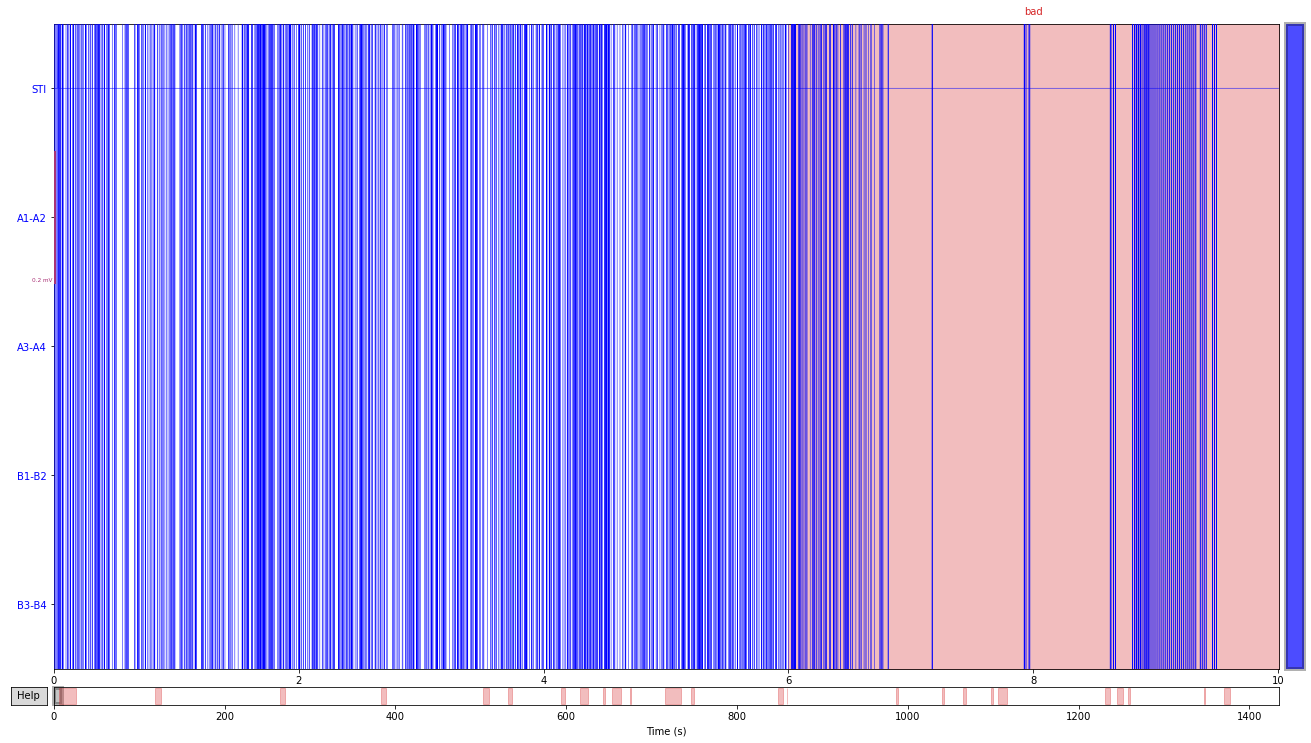

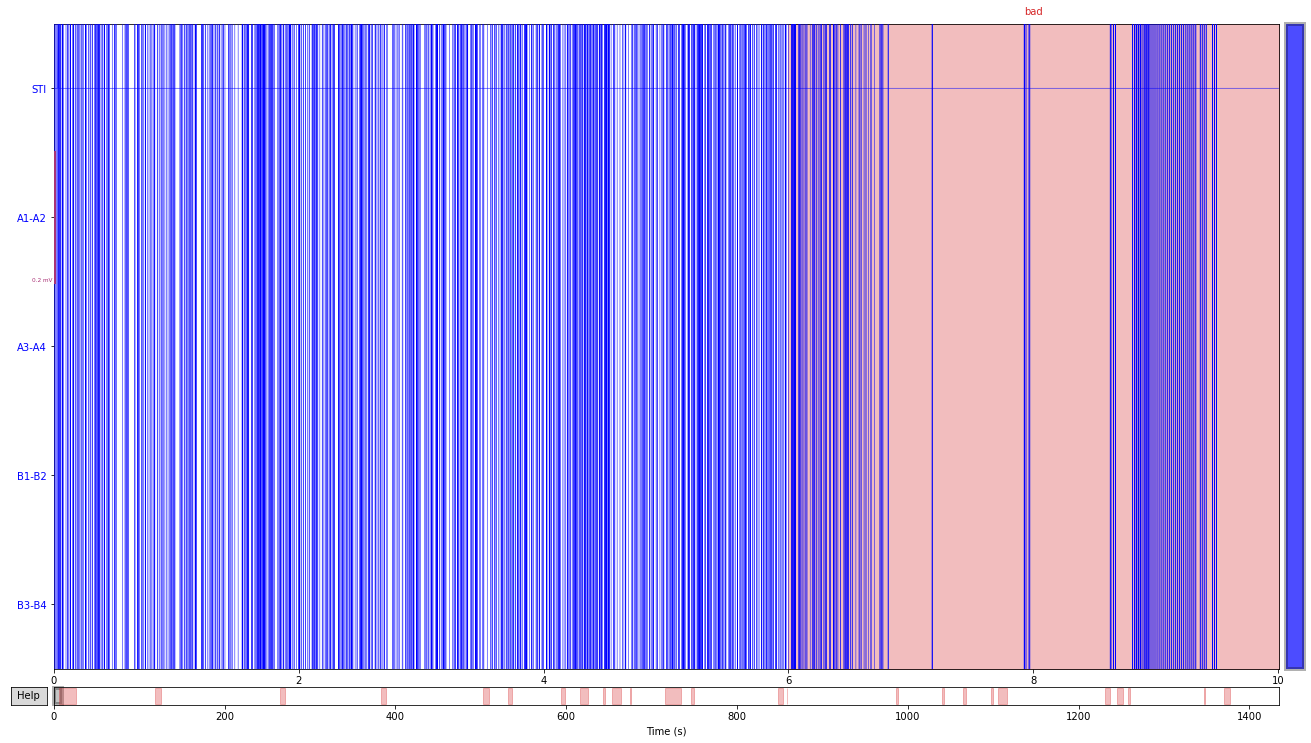

In [131]:
# plot for cleaning #

filtered_notch_data.plot(color='b', bad_color = 'cyan', n_channels = 230, clipping = None, event_color = 'r')

Opening raw-browser...


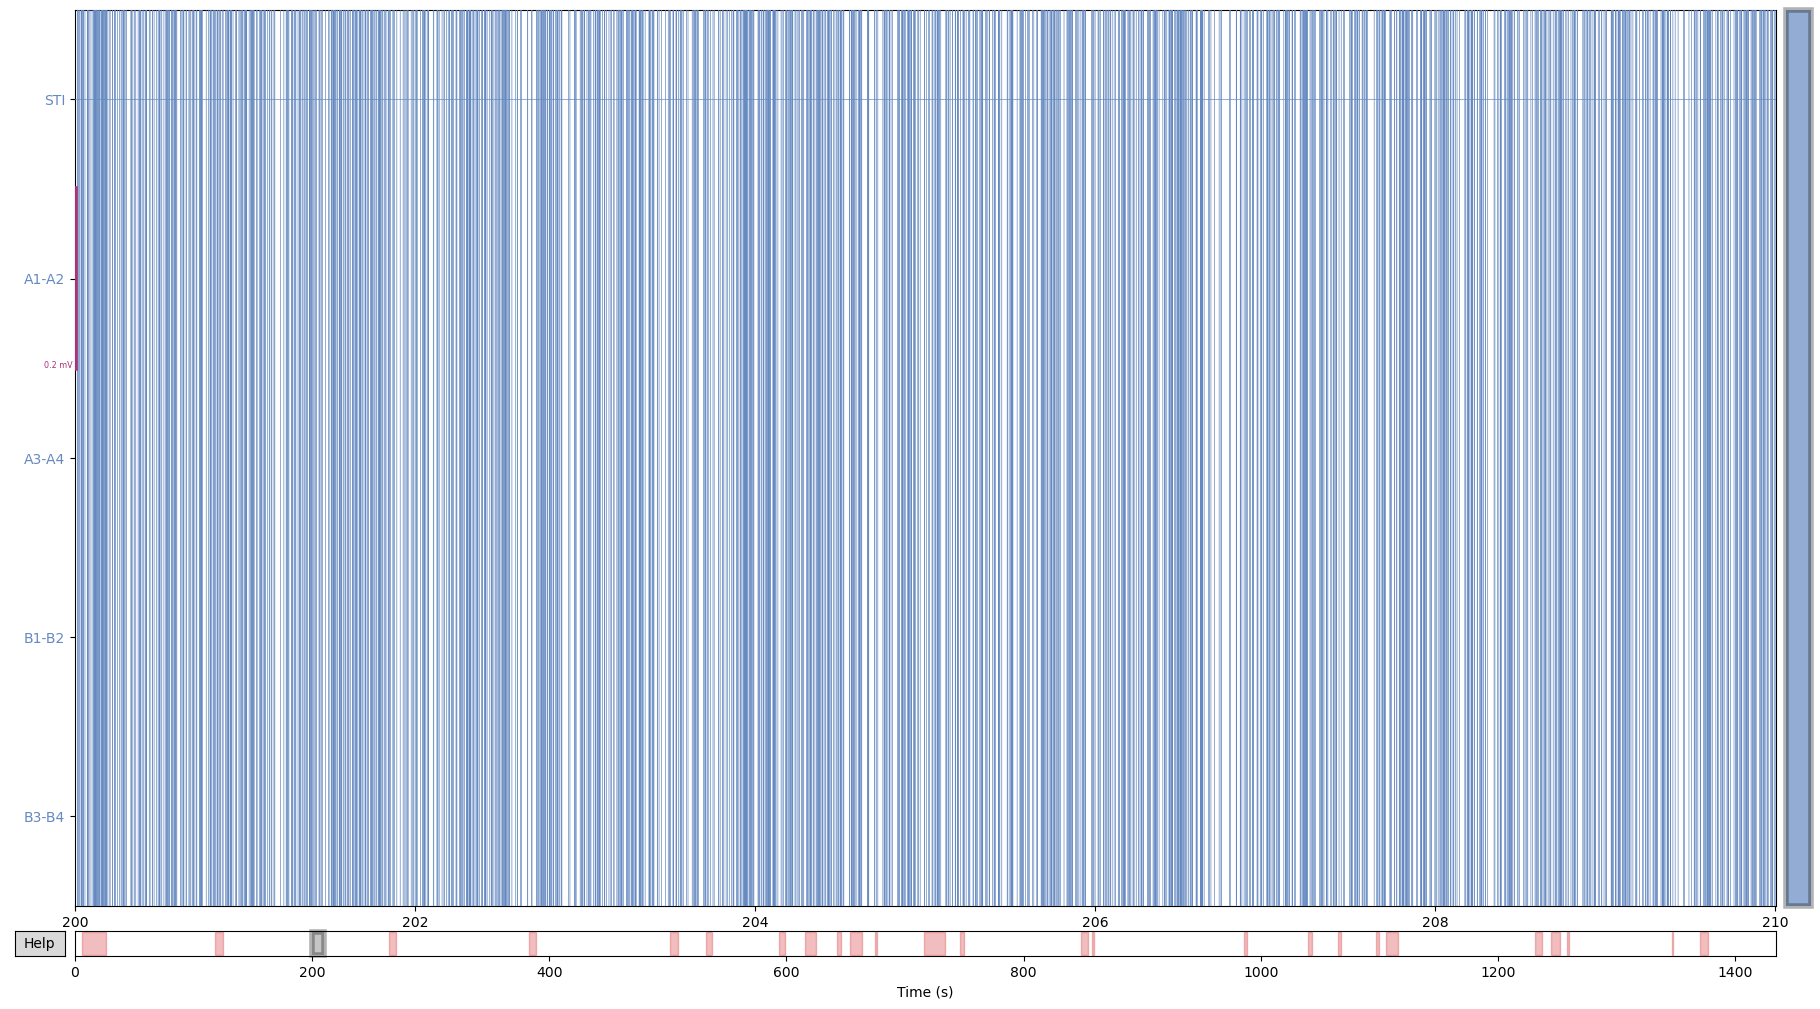

In [150]:
filtered_notch_data.plot(color='#6589C0', bad_color = 'cyan', n_channels = 230, start = 200, clipping = None, event_color = 'r')

In [130]:
filtered_notch_data.info

<Info | 8 non-empty values
 bads: []
 ch_names: A1-A2, A3-A4, B1-B2, B3-B4, STI
 chs: 4 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 1.0 Hz
 lowpass: 124.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 250.0 Hz
>

Setting 38000 of 358586 (10.60%) samples to NaN, retaining 320586 (89.40%) samples.
Effective window size : 8.192 (s)


/tmp/ipykernel_7860/1031403215.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd_fig = filtered_notch_data.plot_psd(average = False, reject_by_annotation = True, fmax = 55, color ='#3A6589', show = True )


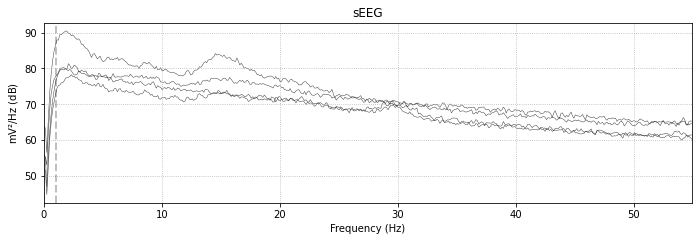

In [132]:
# plot psd of all channels #

psd_fig = filtered_notch_data.plot_psd(average = False, reject_by_annotation = True, fmax = 55, color ='#3A6589', show = True )
# ax = plt.gca()
# ax.set_ylim([50, 90])
# # fig.show()
# psd_fig.savefig('/home/brooke/pacman/raw_data/BNP01/BNP01_psd.png', dpi=600)

In [12]:
neuropace_aray_data = filtered_notch_data.get_data()

neuropace_aray_data = np.expand_dims(neuropace_aray_data, axis = 0)

neuropace_aray_data[:, 0:5, 1:10]

array([[[ 12.70878895,   5.23910022,  -9.60011094, -29.92688961,
         -28.2200905 , -18.27649174,  -2.38584335,  15.15365249,
          18.82197901],
        [-13.63384407, -28.27531531, -40.86445832, -34.01352962,
         -16.06554198,   1.14988819,  24.55882672,  16.9168303 ,
          -3.38927121],
        [ 65.12963688,  99.37165987,  86.70720238,  90.03269439,
          88.85906014,  68.12958657,  42.57661758,  26.13021524,
          18.42284037],
        [ 13.06329684,   4.29327316, -12.13816707, -31.42516296,
         -22.97975862,  -7.1576577 ,  -8.142188  ,  -6.94144528,
           6.089714  ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           1.        ]]])

In [98]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(60), num = 50, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(20), base = 10, num = 50)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)

[ 1.          1.08714832  1.18189148  1.28489134  1.39686747  1.51860213
  1.65094576  1.79482292  1.95123873  2.12128592  2.30615243  2.50712976
  2.72562191  2.9631553   3.22138932  3.502128    3.80733259  4.13913525
  4.49985395  4.89200869  5.31833905  5.78182339  6.28569961  6.8334878
  7.42901482  8.07644102  8.78028932  9.54547683 10.37734915 11.28171774
 12.26490054 13.33376608 14.49578146 15.75906453 17.13244061 18.62550411
 20.24868559 22.01332462 23.93174899 26.01736083 28.28473024 30.7496971
 33.4294817  36.34280503 39.51001961 42.95325164 46.69655557 50.76608216
 55.19026119 60.        ]
[ 2.          2.09622627  2.19708228  2.3027908   2.41358528  2.52971043
  2.65142273  2.77899099  2.91269696  3.05283593  3.19971744  3.35366587
  3.51502125  3.68413994  3.86139546  4.0471793   4.24190178  4.44599297
  4.65990362  4.88410619  5.11909585  5.36539159  5.6235374   5.89410341
  6.17768719  6.47491509  6.78644354  7.11296061  7.45518744  7.81387987
  8.18983012  8.58386852  8

In [99]:
def MM_compute_TFR(arra_data, freqs, n_cycles, zscore=True, time_bandwidth=None, numjs = 8):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_array_morlet(epoch_data = arra_data, sfreq = 250, freqs = freqs ,n_cycles = n_cycles, output = 'power', n_jobs = numjs)
    print('log transforming')
    TFR.data = np.log(TFR.data)
    # if zscore:
    #     print('z-scoring to baseline')
    #     # bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
    #     bmean = TFR.data[:,:,:,:].mean(axis=(0,3),keepdims=True)
    #     bstd = TFR.data[:,:,:,:].std(axis=(0,3),keepdims=True)
    #     TFR.data = (TFR.data - bmean) / bstd
    return TFR

In [100]:
neuropace_TFR = MM_compute_TFR(neuropace_aray_data[:, 0:4, :],freqs,n_cycles,zscore=True , numjs = 8)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    3.7s finished


log transforming


/tmp/ipykernel_7860/2025860519.py:5: RuntimeWarning: divide by zero encountered in log
  TFR.data = np.log(TFR.data)
/tmp/ipykernel_7860/2025860519.py:5: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  TFR.data = np.log(TFR.data)


In [101]:
neuropace_TFR.shape


(1, 4, 50, 358586)

In [102]:
250/4

62.5

In [103]:
bmean = np.ma.masked_invalid(neuropace_TFR[:, :, :, 225000:240000]).mean( axis=(0,3),keepdims=True)
bstd = np.ma.masked_invalid(neuropace_TFR[:, :, :, 225000:240000]).std( axis=(0,3),keepdims=True)
neuropace_TFR_zscore = (neuropace_TFR - bmean) / bstd

In [104]:
16 * 250 * 60

240000

In [105]:
neuropace_TFR_zscore = neuropace_TFR_zscore[:, :, :, 225000:240000]

/tmp/ipykernel_7860/2645807984.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


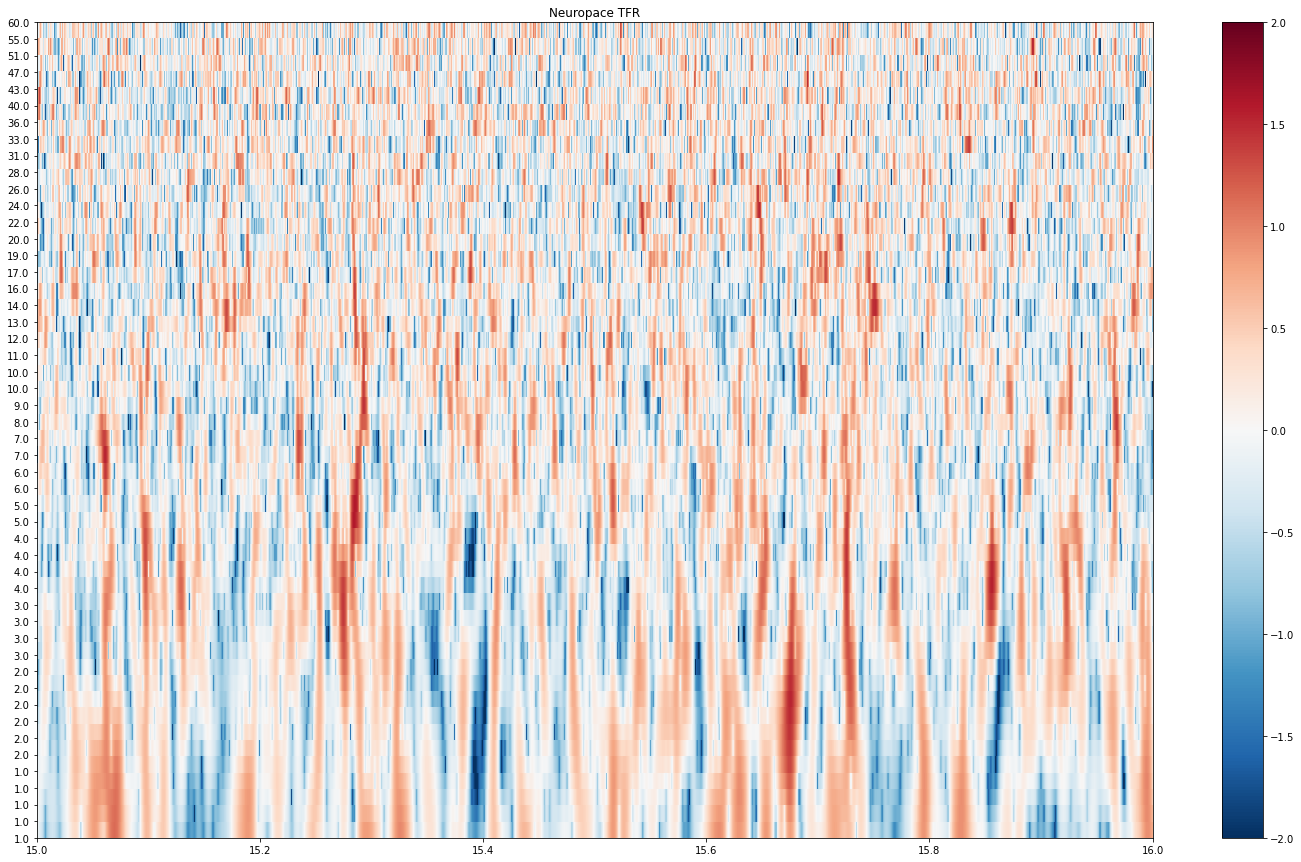

In [108]:
plt.rcParams['figure.figsize'] = [25, 15]

fig, ax = plt.subplots()
i = ax.imshow(neuropace_TFR_zscore.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[225000/250/60, 240000/250/60, freqs[0], freqs[-1]], vmin = -2, vmax = 2)
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Neuropace TFR")
fig.show()


## Save Files

In [79]:
plt.plot(np.arange(15))

In [15]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_notched_filtered_clean_ieeg.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_notched_filtered_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_notched_filtered_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_notched_filtered_clean_ieeg.fif
[done]
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_raw_clean_ieeg.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_raw_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_raw_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/SLCH002/ieeg/SLCH002_raw_clean_ieeg.fif
[done]
